In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("/n/home12/binxuwang/Github/mini_edm")
sys.path.append("/n/home12/binxuwang/Github/DiffusionReasoning")
sys.path.append("/n/home12/binxuwang/Github/DiT")

In [12]:
import glob
import re
from tqdm.auto import tqdm
import time
import os
from os.path import join
import pickle as pkl
import torch
import torch as th
from tqdm import tqdm
import pandas as pd
import numpy as np
import seaborn as sns
import einops
import matplotlib.pyplot as plt
from collections import defaultdict
from easydict import EasyDict as edict
import matplotlib.pyplot as plt 
%matplotlib inline
plt.rcParams['figure.dpi'] = 72
plt.rcParams['figure.figsize'] = [6.0, 4.0]
plt.rcParams['figure.edgecolor'] = (1, 1, 1, 0)
plt.rcParams['figure.facecolor'] = (1, 1, 1, 0)
# vector graphics type
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

In [3]:
# from train_edm import create_model, edm_sampler, EDM
# from edm_utils import edm_sampler_inpaint, create_edm, get_default_config
# from rule_utils import get_rule_img, get_obj_list, get_rule_list
# from rule_utils import check_consistent
from dataset_utils import train_data2attr_tsr,load_raw_data,load_PGM_abstract
from rule_new_utils import check_r3_r2_batch, infer_rule_from_sample_batch, compute_rule_statistics

In [4]:
import circuit_toolkit
from circuit_toolkit.layer_hook_utils import print_specific_layer, get_module_name_shapes, featureFetcher_module
from circuit_toolkit.plot_utils import saveallforms

/n/home12/binxuwang/Github/circuit_toolkit/circuit_toolkit/GAN_invert_utils.py:2: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import trange, tqdm


In [5]:
heldout_id_dict = {
    'train_inputs_new.pt'       : [1, 16, 20, 34, 37], 
    'train_inputs_new_split0.pt': [1, 16, 20, 34, 37], 
    'train_inputs_new_split1.pt': [8, 12, 24, 36, 39],
    'train_inputs_new_split2.pt': [5, 17, 21, 33, 38],
    'train_inputs_new_split3.pt': [3, 10, 29, 31, 37],
    'train_inputs_new_split4.pt': [0, 14, 27, 35, 38],
    'train_inputs_new_split5.pt': [4, 19, 26, 30, 39],
    'train_inputs_new_split6.pt': [9, 13, 25, 32, 37],
    'train_inputs_new_split7.pt': [2, 18, 23, 30, 38],
    'train_inputs_new_split8.pt': [7, 15, 22, 34, 39],
    'train_inputs_new_split9.pt': [6, 11, 28, 33, 37],
}
heldout_rules = heldout_id_dict["train_inputs_new.pt"]

## Paths

In [26]:
tabdir = "/n/home12/binxuwang/Github/DiffusionReasoning/Tables"

GPT_exproot = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/GPT2_raven"
DiT_exproot = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiT/results"
SiT_exproot = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/SiT/results"
SSM_exproot = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/Mamba_raven"
EDM_exproot = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/mini_edm/exps"

figdir = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Figures/DiffusionReasoning"
GPTfigdir = join(figdir, "GPT2_raven")
EDMfigdir = join(figdir, "EDM_raven")
DiTfigdir = join(figdir, "DiT_raven")
SiTfigdir = join(figdir, "SiT_raven")
SSMfigdir = join(figdir, "SSM_raven")
figroot = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Figures/DiffusionReasoning/uncond_sampler_benchmark"

## Sample experiment DiT/s

In [7]:
syndf_diff = pd.read_csv(join(tabdir, "diffusion_family_comb_tensorboard_data_last10.csv"), index_col=0)

In [8]:
syndf_diff.query("model_class == 'DiT' and dataset_size == 0.16 and heldout== True").full_name.to_list()

['090-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout0_20240711-0204/tensorboard_logs',
 '094-RAVEN10_abstract-uncond-DiT_B_1-stream0_16M_heldout0_20240711-0205/tensorboard_logs']

In [9]:

# def sweep_collect_sample(expname, exproot, prefix="", non_prefix=None, format='%07d.pt'):
#     assert os.path.exists(join(exproot, expname, "samples")), expname  
#     # print(sorted(os.listdir(join(exproot, expname, "samples"))))
#     print(f"Extracted data from {join(exproot, expname, 'samples')}")
#     print(f"example file:", os.listdir(join(exproot, expname, 'samples'))[0:10])
#     # for files with names like 'sample_rule_eval_995000.pt' find the one with largest number
#     # TODO: check and fix the prefix prompt
#     epoch_nums = sorted([int(f.split(prefix)[-1].split(".pt")[0]) for f in os.listdir(join(exproot, expname,'samples')) if not (non_prefix in f)])
#     eval_col = {}
#     for epoch_num in tqdm(epoch_nums):
#         samples_eval = torch.load(join(exproot, expname, 'samples', format % epoch_num)) #f"{prefix}{epoch_num:07d}.pt"))
#         eval_col[epoch_num] = samples_eval
#     return eval_col


# def sweep_collect_eval_data(expname, exproot, prefix=None):
#     assert os.path.exists(join(exproot, expname, "samples")), expname  
#     # print(sorted(os.listdir(join(exproot, expname, "samples"))))
#     print(f"Extracted data from {join(exproot, expname, 'samples')}")
#     print(f"example file:", os.listdir(join(exproot, expname, 'samples'))[0])
#     # for files with names like 'sample_rule_eval_995000.pt' find the one with largest number
#     epoch_nums = sorted([int(f.split(prefix)[-1].split(".pt")[0]) for f in os.listdir(join(exproot, expname,'samples')) if prefix in f])
#     eval_col = {}
#     for epoch_num in tqdm(epoch_nums):
#         samples_eval = torch.load(join(exproot, expname, 'samples', f"{prefix}{epoch_num}.pt"))
#         eval_col[epoch_num] = samples_eval
#     return eval_col


In [135]:
def sweep_collect_eval_data_sampler(expdir, stats_only=False):
    file_list = glob.glob(join(expdir, "uncond_samples", "sample_rule_eval_*.pt"))
    # Regular expression to extract parts from the filename
    pattern = r'sample_rule_eval_(\d+)_(ddim|ddpm)(\d+)_rep(\d+)\.pt'
    # Create a list to store the extracted results
    if stats_only:
        extracted_data = []
    else:
        extracted_col = {}
        extracted_data = []
    # Iterate through all matching files
    for file in tqdm(file_list):
        file_name = os.path.basename(file)  # Get the file name only, without the directory path
        match = re.search(pattern, file_name)
        if match:
            epoch = int(match.group(1))  # e.g., 1000000
            sampler = match.group(2)
            steps = int(match.group(3))  # e.g., 200 (from ddim200)
            rep = int(match.group(4))  # e.g., 6 (from rep6)
            # Append the extracted parts to the list
            data = torch.load(file)
            meta = {"file_name": file_name, "epoch": epoch, "sampler": sampler, "steps": steps, "rep": rep}
            if stats_only:
                meta.update({k: data[k] for k in ['c3_cnt', 'c2_cnt', 'anyvalid_cnt', 'total']})
                extracted_data.append(meta)
            else:
                extracted_data.append({**meta, "eval_data": data})
                extracted_col[(epoch, sampler, steps, rep)] = data
        else:
            print(f"Pattern not found in {file_name}")
    print(f"Extracted data from {expdir}")
    print(f"Found {len(extracted_data)} matching files")
    print(f"Example file names: {extracted_data[:5]}")
    if stats_only:
        stats_df = pd.DataFrame(extracted_data)
        stats_df["c3"] = stats_df["c3_cnt"] / stats_df["total"]
        stats_df["c2"] = stats_df["c2_cnt"] / stats_df["total"]
        stats_df["c23"] = stats_df["c3"] + stats_df["c2"]
        stats_df["anyvalid"] = stats_df["anyvalid_cnt"] / stats_df["total"] / 3
        return stats_df
    else:
        return extracted_col

In [27]:
expname = "090-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout0_20240711-0204"
expdir = join(DiT_exproot, expname)
figexpdir = join(figroot, expname)
os.makedirs(figexpdir, exist_ok=True)

In [28]:
eval_stats_df = sweep_collect_eval_data_sampler(expdir, stats_only=True)

  0%|                                                                                                                                        | 0/160 [00:00<?, ?it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 160/160 [00:05<00:00, 29.90it/s]


Extracted data from /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiT/results/090-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout0_20240711-0204
Found 160 matching files
Example file names: [{'file_name': 'sample_rule_eval_1000000_ddim200_rep6.pt', 'epoch': 1000000, 'sampler': 'ddim', 'steps': 200, 'rep': 6, 'c3_cnt': 1256, 'c2_cnt': 258, 'anyvalid_cnt': 4744, 'total': 2048}, {'file_name': 'sample_rule_eval_1000000_ddpm500_rep1.pt', 'epoch': 1000000, 'sampler': 'ddpm', 'steps': 500, 'rep': 1, 'c3_cnt': 1433, 'c2_cnt': 201, 'anyvalid_cnt': 5009, 'total': 2048}, {'file_name': 'sample_rule_eval_1000000_ddpm200_rep4.pt', 'epoch': 1000000, 'sampler': 'ddpm', 'steps': 200, 'rep': 4, 'c3_cnt': 1388, 'c2_cnt': 204, 'anyvalid_cnt': 4890, 'total': 2048}, {'file_name': 'sample_rule_eval_1000000_ddpm20_rep5.pt', 'epoch': 1000000, 'sampler': 'ddpm', 'steps': 20, 'rep': 5, 'c3_cnt': 513, 'c2_cnt': 303, 'anyvalid_cnt': 2894, 'total': 2048}, {'file_name': 'sample_rule_eval

In [29]:
eval_stats_df["c3"] = eval_stats_df["c3_cnt"] / eval_stats_df["total"]
eval_stats_df["c2"] = eval_stats_df["c2_cnt"] / eval_stats_df["total"]
eval_stats_df["c23"] = eval_stats_df["c3"] + eval_stats_df["c2"]
eval_stats_df["anyvalid"] = eval_stats_df["anyvalid_cnt"] / eval_stats_df["total"] / 3
eval_stats_df.to_csv(join(figexpdir, "sampler_eval_stats.csv"))

### Summary scaling plots

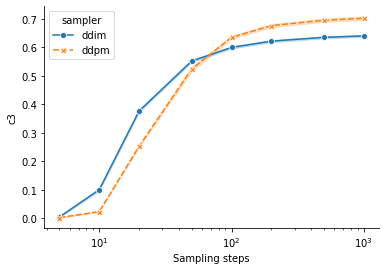

In [18]:
sns.lineplot(data=eval_stats_df, x="steps", y="c3", style="sampler", hue='sampler', markers=True)
# sns.lineplot(data=eval_stats_df, x="steps", y="c2", style="sampler", label="c2")
plt.xlabel("Sampling steps")
plt.xscale("log")
plt.show()

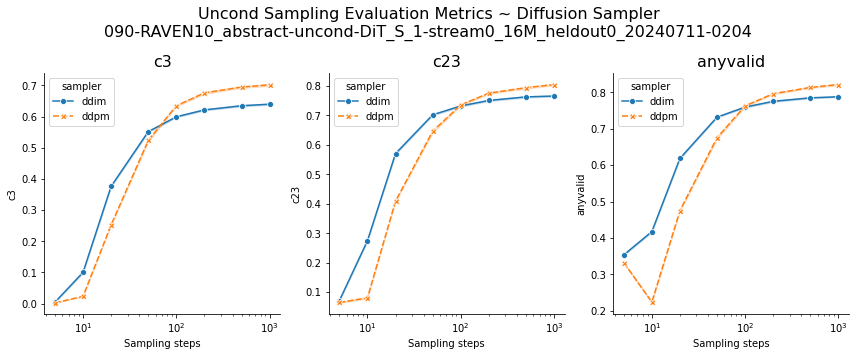

In [34]:
figh, axs = plt.subplots(1, 3, figsize=(12, 5))
for ax, metric in zip(axs, ["c3", "c23", "anyvalid"]):
    sns.lineplot(data=eval_stats_df, x="steps", y=metric, style="sampler", hue='sampler', markers=True, ax=ax, errorbar='se')
    ax.set_xlabel("Sampling steps")
    ax.set_xscale("log")
    ax.set_title(metric, fontsize=16)
plt.suptitle(f"Uncond Sampling Evaluation Metrics ~ Diffusion Sampler\n{expname}", fontsize=16)
plt.tight_layout()
saveallforms(figexpdir, "sampler_eval_metric_summary", figh)
plt.show()

### Rule separated plot for each sampler

In [58]:
from posthoc_analysis_utils import extract_rule_list_from_eval_col, extract_rule_list_from_eval_col_Diffusion, format_rule_list_to_mat
from rule_new_utils import relation_dict, attribute_dict
from stats_plot_utils import add_rectangles, plot_rule_heatmap

def plot_rule_heatmap(rule_mat, title="Rule Heatmap", 
                      heldout_rules=(1, 16, 20, 34, 37),
                      ax=None, cmap="viridis", fmt=".2f"):
    if ax is None:
        figh = plt.figure(figsize=(10, 5))
        ax = figh.add_subplot(111)
    plt.sca(ax)
    sns.heatmap(rule_mat, cmap=cmap, annot=True, fmt=fmt, ax=ax)
    plt.axis("image")
    add_rectangles(heldout_rules)
    plt.xticks(np.arange(10)+0.5, [relation_dict[i] for i in range(10)], rotation=45)
    plt.yticks(np.arange(4)+0.5, [attribute_dict[i] for i in range(4)], rotation=0)
    ax.set_title(title)
    return figh


In [59]:
eval_col = sweep_collect_eval_data_sampler(expdir, stats_only=False)
meta_list, rule_list_all, consistency_all = extract_rule_list_from_eval_col_Diffusion(eval_col, sort_key=False)
rule_cnt_mat, cons3_rule_cnt_mat, cons2_rule_cnt_mat = format_rule_list_to_mat(rule_list_all, consistency_all)
meta_df = pd.DataFrame(meta_list, columns=["epoch", "sampler", "steps", "rep"])

  0%|                                                                                                                                        | 0/160 [00:00<?, ?it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 160/160 [00:03<00:00, 51.26it/s]


Extracted data from /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiT/results/090-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout0_20240711-0204
Found 160 matching files
Example file names: [{'file_name': 'sample_rule_eval_1000000_ddim200_rep6.pt', 'epoch': 1000000, 'sampler': 'ddim', 'steps': 200, 'rep': 6, 'eval_data': {'c3_list': [[30], [0], [11], [], [], [], [], [], [38], [30], [21], [], [10], [], [31], [33], [30], [6], [36], [5], [8], [4], [3], [30], [], [], [23], [24], [26], [], [2], [11], [], [23], [], [36], [38], [2], [6], [], [11], [3], [], [], [], [6], [39], [], [13], [10], [], [12], [23], [], [], [33], [8], [38], [12], [23], [23], [], [21], [], [2], [24], [], [], [29], [], [3], [], [36], [11], [39], [25], [21], [4], [14], [24], [], [12], [], [], [], [12], [], [32], [10], [0], [14], [39], [14], [21], [30], [33], [], [33], [], [31], [12], [35], [], [], [15], [], [24], [13], [], [36], [], [32], [11], [], [3], [32], [0], [32], [32], [], [], [24], [],

In [62]:
sampler = "ddpm"
steps = 1000
mask = (meta_df.sampler == sampler) & (meta_df.steps == steps)
mask = mask.to_numpy()
C3_avg = cons3_rule_cnt_mat[mask].sum(axis=1).mean(axis=0) / 2048
valid_avg = rule_cnt_mat[mask].sum(axis=1).mean(axis=0) / 2048 / 3
C3_vec = cons3_rule_cnt_mat[mask].mean(axis=0) / 2048 
valid_vec = rule_cnt_mat[mask].mean(axis=0) / 2048 / 3

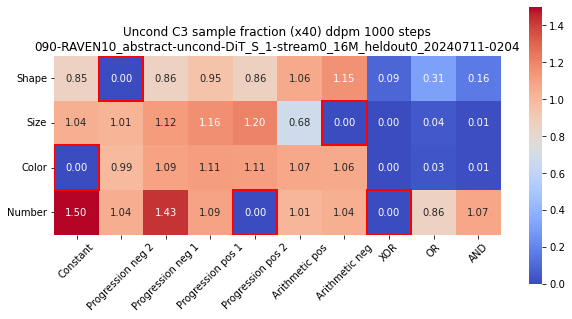

In [72]:
figh = plot_rule_heatmap(C3_vec.reshape(4, 10) * 40, cmap="coolwarm",
        title=f"Uncond C3 sample fraction (x40) {sampler} {steps} steps\n{expname}",)
figh.show()

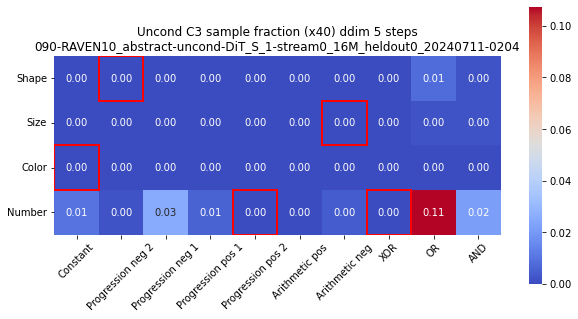

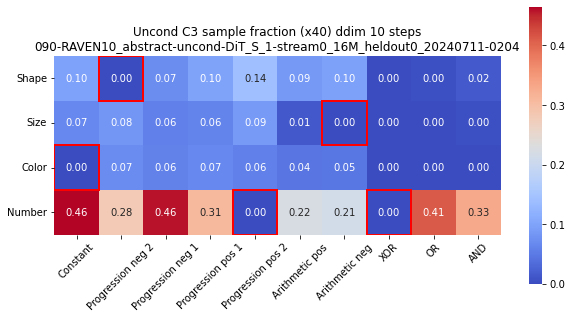

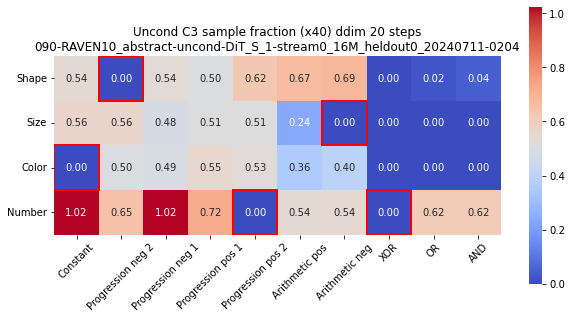

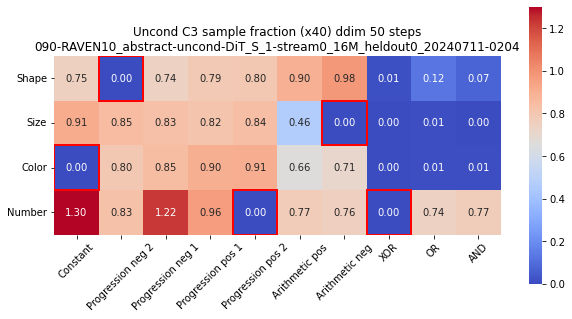

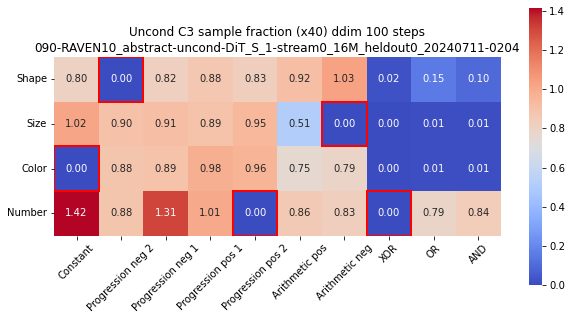

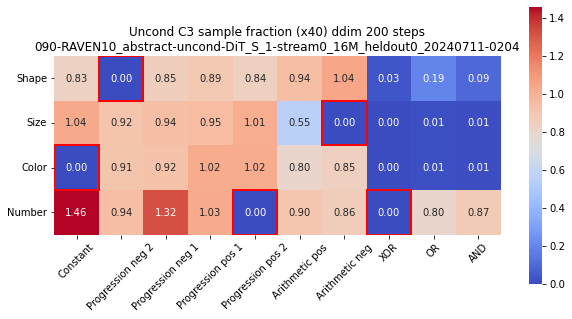

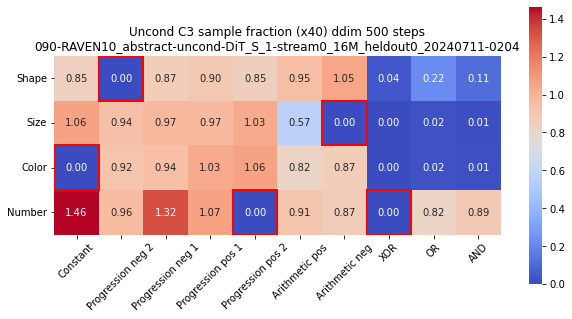

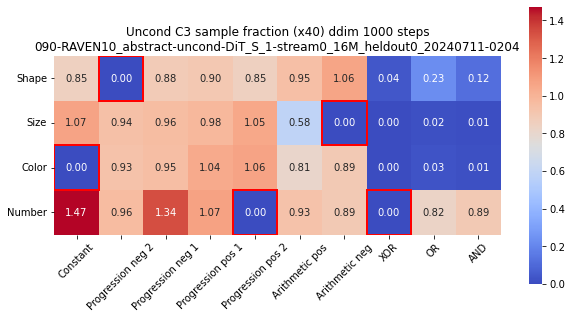

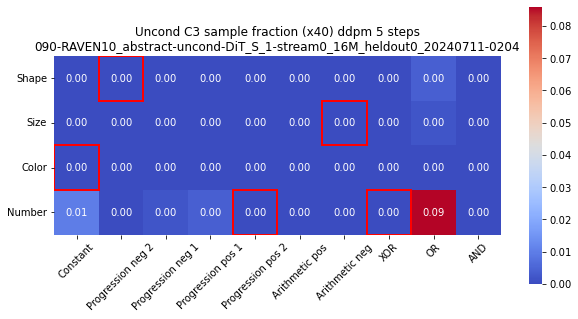

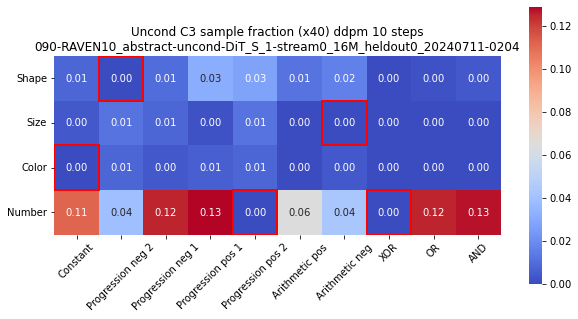

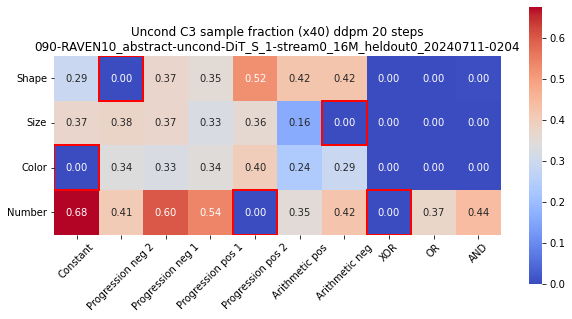

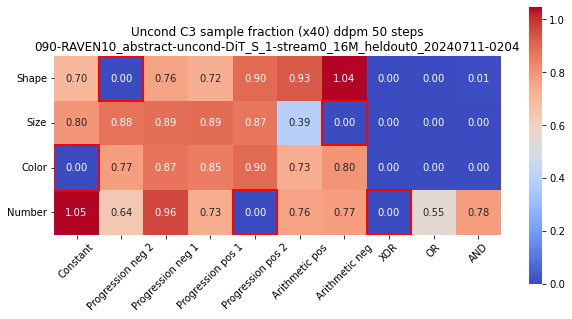

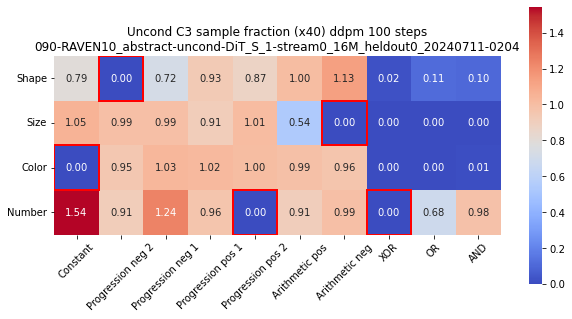

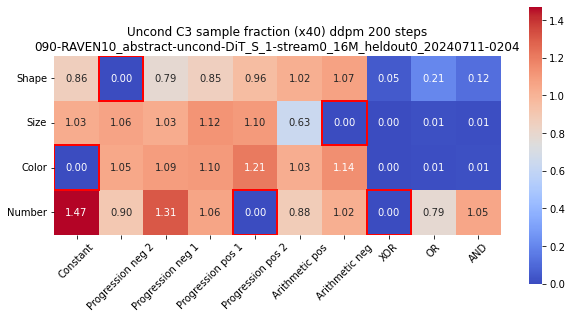

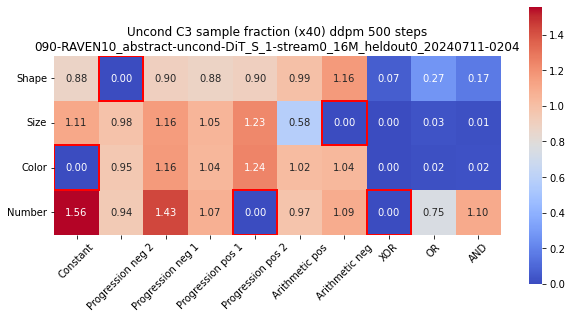

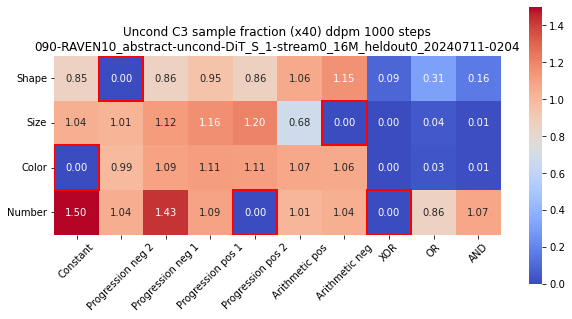

In [75]:
sampler = "ddpm"
steps = 1000
for sampler in meta_df.sampler.unique():
    for steps in sorted(meta_df.steps.unique()):
        mask = (meta_df.sampler == sampler) & (meta_df.steps == steps)
        # mask = mask.to_numpy()
        C3_avg = cons3_rule_cnt_mat[mask].sum(axis=1).mean(axis=0) / 2048
        valid_avg = rule_cnt_mat[mask].sum(axis=1).mean(axis=0) / 2048 / 3
        C3_vec = cons3_rule_cnt_mat[mask].mean(axis=0) / 2048 
        valid_vec = rule_cnt_mat[mask].mean(axis=0) / 2048 / 3
        figh = plot_rule_heatmap(C3_vec.reshape(4, 10) * 40, cmap="coolwarm",
                title=f"Uncond C3 sample fraction (x40) {sampler} {steps} steps\n{expname}",)
        saveallforms(figexpdir, f"rule_heatmap_C3_{sampler}_{steps}", figh)
        figh.show()
        figh2 = plot_rule_heatmap(valid_vec.reshape(4, 10) * 40, cmap="coolwarm",
                title=f"Uncond valid row fraction (x40) {sampler} {steps} steps\n{expname}",)
        saveallforms(figexpdir, f"rule_heatmap_valid_{sampler}_{steps}", figh2)
        plt.close(figh2)

### Group comparison

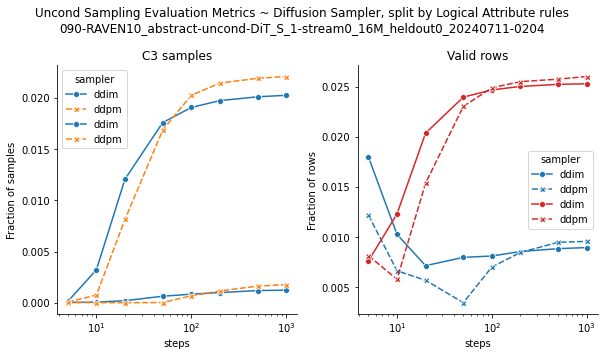

In [99]:
rule_ids = np.arange(40)
rule_mask = (rule_ids % 10 >= 7) & (rule_ids  <= 30)
sum_plot_df = []
for sampler in meta_df.sampler.unique():
    for steps in sorted(meta_df.steps.unique()):
        mask = (meta_df.sampler == sampler) & (meta_df.steps == steps)
        # mask = mask.to_numpy()
        C3_avg = cons3_rule_cnt_mat[mask].sum(axis=1).mean(axis=0) / 2048
        valid_avg = rule_cnt_mat[mask].sum(axis=1).mean(axis=0) / 2048 / 3
        C3_vec = cons3_rule_cnt_mat[mask].mean(axis=0) / 2048 
        valid_vec = rule_cnt_mat[mask].mean(axis=0) / 2048 / 3
        inmask_C3 = C3_vec[rule_mask].mean()
        outmask_C3 = C3_vec[~rule_mask].mean()
        inmask_valid = valid_vec[rule_mask].mean()
        outmask_valid = valid_vec[~rule_mask].mean()
        sum_plot_df.append({"sampler": sampler, "steps": steps, "inmask_C3": inmask_C3, "outmask_C3": outmask_C3,
                            "inmask_valid": inmask_valid, "outmask_valid": outmask_valid})

sum_plot_df = pd.DataFrame(sum_plot_df)
figh, axs = plt.subplots(1, 2, figsize=(8.5, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=sum_plot_df, x="steps", y="inmask_C3", style="sampler", hue='sampler', markers=True)
sns.lineplot(data=sum_plot_df, x="steps", y="outmask_C3", style="sampler", hue='sampler', markers=True)
plt.xscale("log")
plt.ylabel("Fraction of samples")
plt.title("C3 samples")
plt.subplot(1, 2, 2)
sns.lineplot(data=sum_plot_df, x="steps", y="inmask_valid", style="sampler", markers=True, color="tab:blue") #hue='sampler', 
sns.lineplot(data=sum_plot_df, x="steps", y="outmask_valid", style="sampler", markers=True, color="tab:red") #hue='sampler', 
plt.xscale("log")
plt.ylabel("Fraction of rows")
plt.title("Valid rows")
plt.suptitle(f"Uncond Sampling Evaluation Metrics ~ Diffusion Sampler, split by Logical Attribute rules\n{expname}",)
plt.tight_layout()
saveallforms(figexpdir, "sampler_eval_metric_rule_split_logicattr", figh)
plt.show()

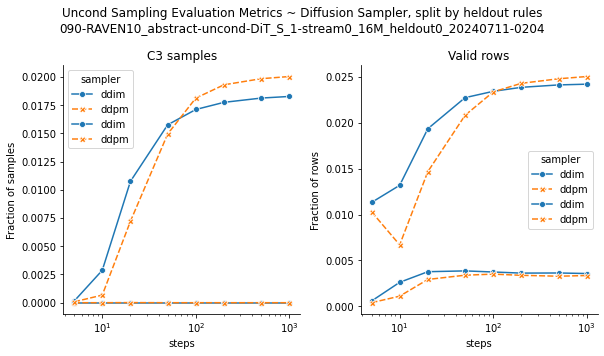

In [98]:
# rule_ids = np.arange(40)
rule_mask = np.zeros(40, dtype=bool)
rule_mask[heldout_rules] = True
sum_plot_df = []
for sampler in meta_df.sampler.unique():
    for steps in sorted(meta_df.steps.unique()):
        mask = (meta_df.sampler == sampler) & (meta_df.steps == steps)
        # mask = mask.to_numpy()
        C3_avg = cons3_rule_cnt_mat[mask].sum(axis=1).mean(axis=0) / 2048
        valid_avg = rule_cnt_mat[mask].sum(axis=1).mean(axis=0) / 2048 / 3
        C3_vec = cons3_rule_cnt_mat[mask].mean(axis=0) / 2048 
        valid_vec = rule_cnt_mat[mask].mean(axis=0) / 2048 / 3
        inmask_C3 = C3_vec[rule_mask].mean()
        outmask_C3 = C3_vec[~rule_mask].mean()
        inmask_valid = valid_vec[rule_mask].mean()
        outmask_valid = valid_vec[~rule_mask].mean()
        sum_plot_df.append({"sampler": sampler, "steps": steps, "inmask_C3": inmask_C3, "outmask_C3": outmask_C3,
                            "inmask_valid": inmask_valid, "outmask_valid": outmask_valid})

sum_plot_df = pd.DataFrame(sum_plot_df)
figh, axs = plt.subplots(1, 2, figsize=(8.5, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=sum_plot_df, x="steps", y="inmask_C3", style="sampler", hue='sampler', markers=True)
sns.lineplot(data=sum_plot_df, x="steps", y="outmask_C3", style="sampler", hue='sampler', markers=True)
plt.xscale("log")
plt.ylabel("Fraction of samples")
plt.title("C3 samples")
plt.subplot(1, 2, 2)
sns.lineplot(data=sum_plot_df, x="steps", y="inmask_valid", style="sampler", hue='sampler', markers=True)
sns.lineplot(data=sum_plot_df, x="steps", y="outmask_valid", style="sampler", hue='sampler', markers=True)
plt.xscale("log")
plt.ylabel("Fraction of rows")
plt.title("Valid rows")
plt.suptitle(f"Uncond Sampling Evaluation Metrics ~ Diffusion Sampler, split by heldout rules\n{expname}", )
plt.tight_layout()
saveallforms(figexpdir, "sampler_eval_metric_rule_split_train_heldout", figh)
plt.show()

## EDM

In [105]:
syndf_diff.query("model_class == 'EDM' and dataset_size == 0.16 and heldout== False").full_name.to_list()

['BaseBlnrX3_new_stream0_16M_RAVEN10_abstract_20240921-2218/tensorboard_logs',
 'BigBlnrX3_new_stream0_16M_RAVEN10_abstract_20240828-1332/tensorboard_logs',
 'WideBlnrX3_new_stream0_16M_RAVEN10_abstract_20240705-1908/tensorboard_logs']

In [158]:
expname = "WideBlnrX3_new_stream0_16M_heldout0_RAVEN10_abstract_20240708-2054"
# expname = "WideBlnrX3_new_stream0_16M_RAVEN10_abstract_20240705-1908"
# expname = "BaseBlnrX3_new_stream0_16M_RAVEN10_abstract_20240921-2218"
expdir = join(EDM_exproot, expname)
figexpdir = join(figroot, expname)
os.makedirs(figexpdir, exist_ok=True)

In [159]:
def sweep_collect_eval_data_sampler_EDM(expdir, stats_only=False):
    file_list = glob.glob(join(expdir, "uncond_samples", "sample_rule_eval_*.pt"))
    # Regular expression to extract parts from the filename
    # pattern = r'sample_rule_eval_(\d+)_(Heun|ddim|ddpm)(\d+)_rep(\d+)\.pt'
    pattern_stoch = r'sample_rule_eval_(\d+)_(Heun|HeunStoch)(\d+)_S_churn(\d+)_S_min([\d.]+)_S_max(\d+)_S_noise([\d.]+)_rep(\d+)\.pt'
    pattern_stoch_whole = r'sample_rule_eval_(\d+)_(Heun|HeunStoch)(\d+)_(S_churn\d+_S_min[\d.]+_S_max\d+_S_noise[\d.]+_|)rep(\d+)\.pt'
    pattern_deter = r'sample_rule_eval_(\d+)_(Heun|HeunStoch)(\d+)_rep(\d+)\.pt'

    # Create a list to store the extracted results
    if stats_only:
        extracted_data = []
    else:
        extracted_col = {}
        extracted_data = []
    # Iterate through all matching files
    for file in tqdm(file_list):
        file_name = os.path.basename(file)  # Get the file name only, without the directory path
        match = re.search(pattern_deter, file_name)
        match_stoch = re.search(pattern_stoch, file_name)
        if match:
            epoch = int(match.group(1))  # e.g., 1000000
            sampler = match.group(2)
            steps = int(match.group(3))  # e.g., 200 (from ddim200)
            rep = int(match.group(4))  # e.g., 6 (from rep6)
            S_churn = None
            S_min = None
            S_max = None
            S_noise = None
            param_str = ""
            meta = {"file_name": file_name, "epoch": epoch, "sampler": sampler, "steps": steps, "rep": rep, "param_str": param_str}
        elif match_stoch:
            epoch = int(match_stoch.group(1))  # e.g., 1000000
            sampler = match_stoch.group(2)
            steps = int(match_stoch.group(3))  # e.g., 200 (from ddim200)
            S_churn = int(match_stoch.group(4))
            S_min = float(match_stoch.group(5))
            S_max = int(match_stoch.group(6))
            S_noise = float(match_stoch.group(7))
            param_str = f"S_churn{S_churn}_S_min{S_min}_S_max{S_max}_S_noise{S_noise}"
            rep = int(match_stoch.group(8))
            meta = {"file_name": file_name, "epoch": epoch, "sampler": sampler, "steps": steps, "param_str": param_str,
                    "S_churn": S_churn, "S_min": S_min, "S_max": S_max, "S_noise": S_noise, "rep": rep}
        else:
            print(f"Pattern not found in {file_name}")
            continue
        # Append the extracted parts to the list
        data = torch.load(file)
        if stats_only:
            meta.update({k: data[k] for k in ['c3_cnt', 'c2_cnt', 'anyvalid_cnt', 'total']})
            extracted_data.append(meta)
        else:
            extracted_data.append({**meta, "eval_data": data})
            extracted_col[(epoch, sampler, steps, rep, param_str)] = data
    print(f"Extracted data from {expdir}")
    print(f"Found {len(extracted_data)} matching files")
    print(f"Example file names: {extracted_data[:5]}")
    if stats_only:
        stats_df = pd.DataFrame(extracted_data)
        stats_df["c3"] = stats_df["c3_cnt"] / stats_df["total"]
        stats_df["c2"] = stats_df["c2_cnt"] / stats_df["total"]
        stats_df["c23"] = stats_df["c3"] + stats_df["c2"]
        stats_df["anyvalid"] = stats_df["anyvalid_cnt"] / stats_df["total"] / 3
        return stats_df
    else:
        return extracted_col

In [160]:
pattern_stoch = r'sample_rule_eval_(\d+)_(Heun|HeunStoch)(\d+)_S_churn(\d+)_S_min([\d.]+)_S_max(\d+)_S_noise([\d.]+)_rep(\d+)\.pt'
pattern_deter = r'sample_rule_eval_(\d+)_(Heun|HeunStoch)(\d+)_rep(\d+)\.pt'
re.search(pattern_stoch, "sample_rule_eval_999999_HeunStoch100_S_churn40_S_min0.05_S_max50_S_noise1.003_rep1.pt").groups()

('999999', 'HeunStoch', '100', '40', '0.05', '50', '1.003', '1')

In [161]:
# r'sample_rule_eval_(\d+)_HeunStoch(\d+)_S_churn(\d+)_S_min([\d.]+)_S_max(\d+)_S_noise([\d.]+)_rep(\d+)\.pt'
eval_stats_df_edm = sweep_collect_eval_data_sampler_EDM(expdir, stats_only=True)

  0%|                                                                                                                                        | 0/125 [00:00<?, ?it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [00:03<00:00, 31.46it/s]

Extracted data from /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/mini_edm/exps/WideBlnrX3_new_stream0_16M_heldout0_RAVEN10_abstract_20240708-2054
Found 125 matching files
Example file names: [{'file_name': 'sample_rule_eval_999999_HeunStoch100_S_churn40_S_min0.05_S_max50_S_noise1.003_rep1.pt', 'epoch': 999999, 'sampler': 'HeunStoch', 'steps': 100, 'param_str': 'S_churn40_S_min0.05_S_max50_S_noise1.003', 'S_churn': 40, 'S_min': 0.05, 'S_max': 50, 'S_noise': 1.003, 'rep': 1, 'c3_cnt': 1203, 'c2_cnt': 270, 'anyvalid_cnt': 4605, 'total': 2048}, {'file_name': 'sample_rule_eval_999999_HeunStoch10_S_churn80_S_min0.05_S_max1_S_noise1.007_rep1.pt', 'epoch': 999999, 'sampler': 'HeunStoch', 'steps': 10, 'param_str': 'S_churn80_S_min0.05_S_max1_S_noise1.007', 'S_churn': 80, 'S_min': 0.05, 'S_max': 1, 'S_noise': 1.007, 'rep': 1, 'c3_cnt': 528, 'c2_cnt': 519, 'anyvalid_cnt': 3820, 'total': 2048}, {'file_name': 'sample_rule_eval_999999_HeunStoch5_S_churn80_S_min0.05_S_max50_

In [162]:
eval_stats_df_edm["c3"] = eval_stats_df_edm["c3_cnt"] / eval_stats_df_edm["total"]
eval_stats_df_edm["c2"] = eval_stats_df_edm["c2_cnt"] / eval_stats_df_edm["total"]
eval_stats_df_edm["c23"] = eval_stats_df_edm["c3"] + eval_stats_df_edm["c2"]
eval_stats_df_edm["anyvalid"] = eval_stats_df_edm["anyvalid_cnt"] / eval_stats_df_edm["total"] / 3
eval_stats_df_edm.to_csv(join(figexpdir, "sampler_eval_stats.csv"))

### Summary plots

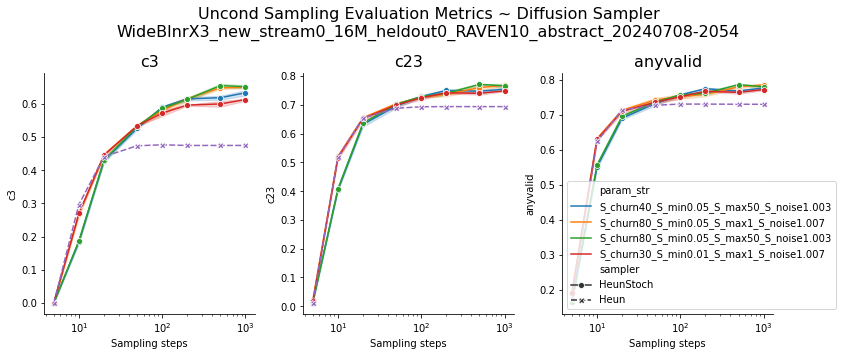

In [164]:
figh, axs = plt.subplots(1, 3, figsize=(12, 5))
for ax, metric in zip(axs, ["c3", "c23", "anyvalid"]):
    sns.lineplot(data=eval_stats_df_edm, x="steps", y=metric, errorbar='se',
             style="sampler", hue='param_str', markers=True, ax=ax,
             legend=False if ax != axs[-1] else True)
    ax.set_xlabel("Sampling steps")
    ax.set_xscale("log")
    ax.set_title(metric, fontsize=16)
plt.suptitle(f"Uncond Sampling Evaluation Metrics ~ Diffusion Sampler\n{expname}", fontsize=16)
plt.tight_layout()
saveallforms(figexpdir, "sampler_eval_metric_summary", figh)
plt.show()

### Rule specific analysis

In [166]:
eval_col = sweep_collect_eval_data_sampler_EDM(expdir, stats_only=False)
meta_list, rule_list_all, consistency_all = extract_rule_list_from_eval_col_Diffusion(eval_col, sort_key=False)
rule_cnt_mat, cons3_rule_cnt_mat, cons2_rule_cnt_mat = format_rule_list_to_mat(rule_list_all, consistency_all)
meta_df = pd.DataFrame(meta_list, columns=["epoch", "sampler", "steps", "rep", "param_str"])
meta_df["sampler"] = meta_df["sampler"] + "_" + meta_df["param_str"]

  0%|                                                                                                                                        | 0/125 [00:00<?, ?it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [00:04<00:00, 26.38it/s]


Extracted data from /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/mini_edm/exps/WideBlnrX3_new_stream0_16M_heldout0_RAVEN10_abstract_20240708-2054
Found 125 matching files
Example file names: [{'file_name': 'sample_rule_eval_999999_HeunStoch100_S_churn40_S_min0.05_S_max50_S_noise1.003_rep1.pt', 'epoch': 999999, 'sampler': 'HeunStoch', 'steps': 100, 'param_str': 'S_churn40_S_min0.05_S_max50_S_noise1.003', 'S_churn': 40, 'S_min': 0.05, 'S_max': 50, 'S_noise': 1.003, 'rep': 1, 'eval_data': {'c3_list': [[26], [22], [0], [14], [23], [39], [11], [], [15], [11], [33], [11], [], [15], [], [], [13], [], [], [11], [], [], [38], [33], [], [], [], [35], [15], [], [13], [24], [14], [12], [10], [], [12], [], [0], [35], [11], [], [], [12], [10], [], [11], [], [13], [14], [], [], [24], [], [30], [], [], [39], [12], [31], [4], [], [24], [], [3], [], [13], [], [0], [2], [], [], [35], [12], [26], [21], [], [4], [38], [13], [25], [], [13], [], [], [2], [], [], [11], [21], [0], [],

/tmp/ipykernel_1875141/700650545.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  figh = plt.figure(figsize=(10, 5))
/tmp/ipykernel_1875141/700650545.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  figh = plt.figure(figsize=(10, 5))


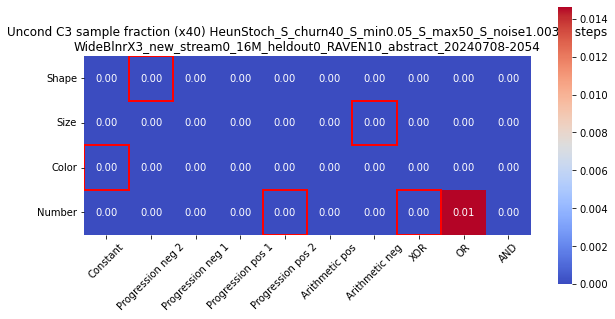

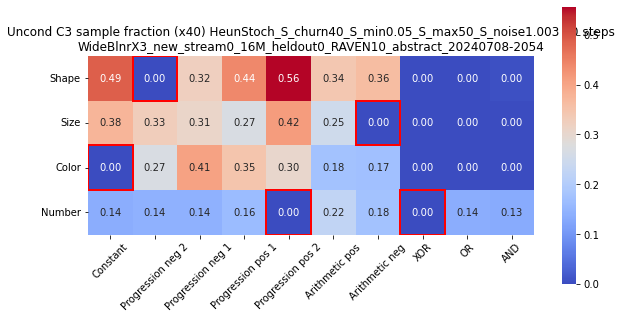

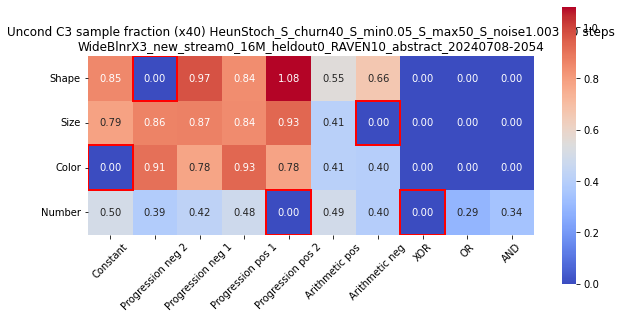

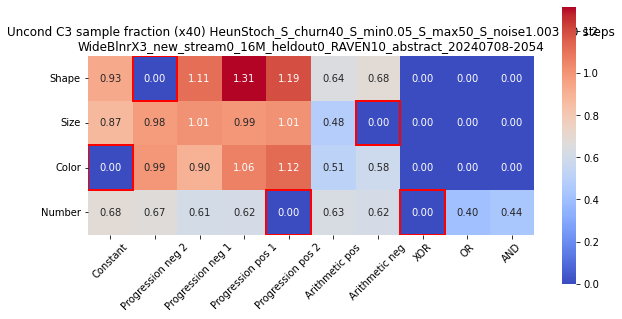

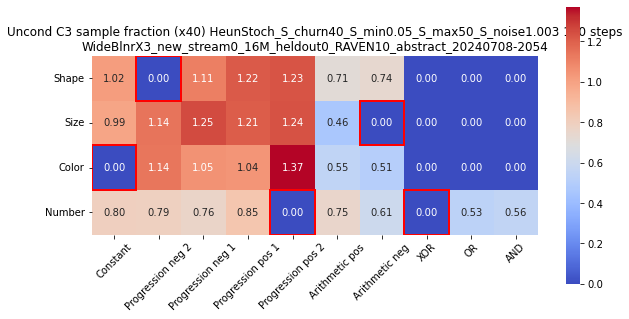

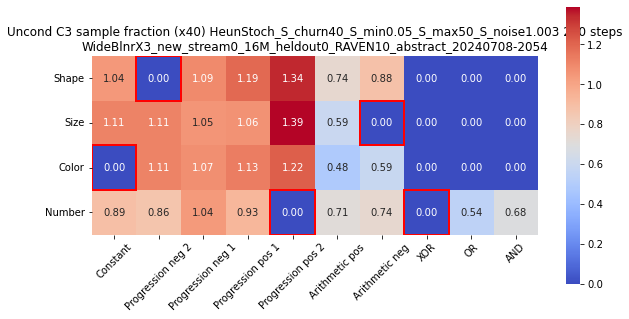

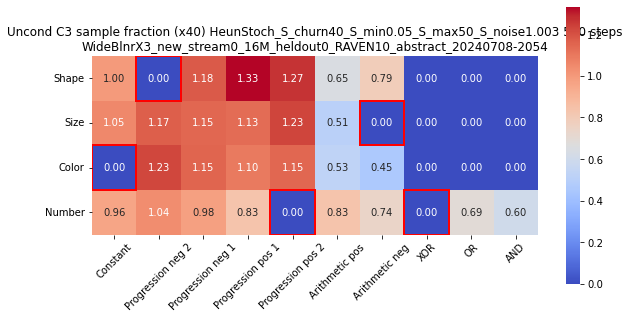

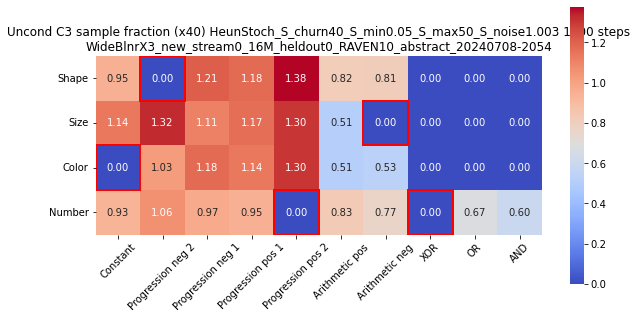

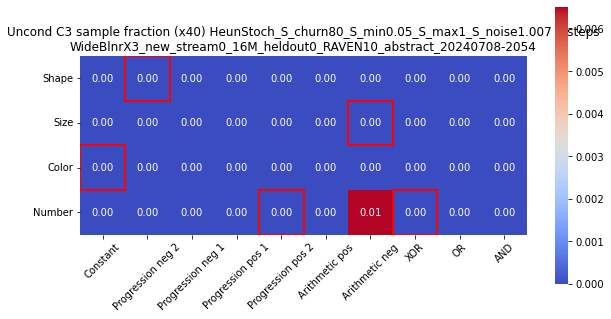

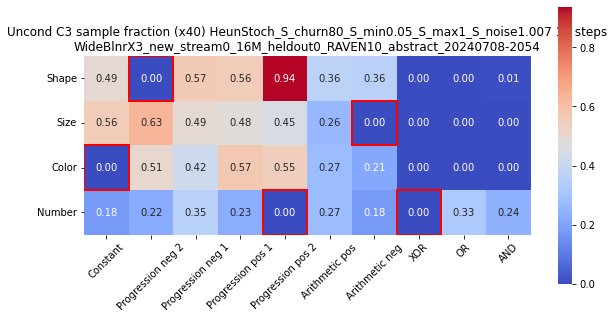

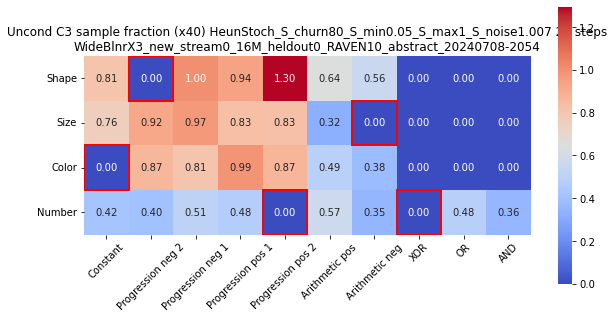

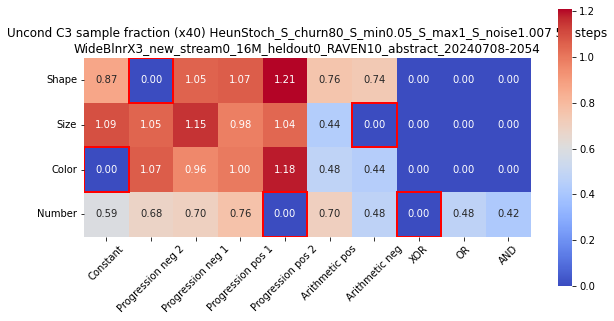

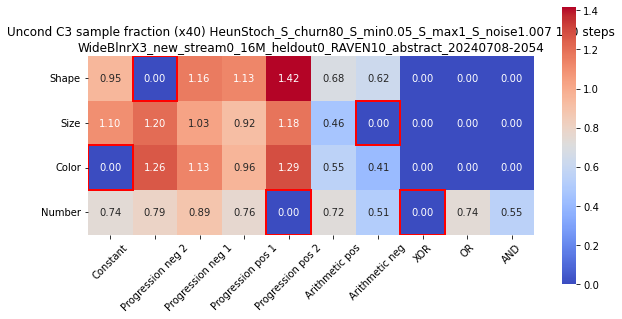

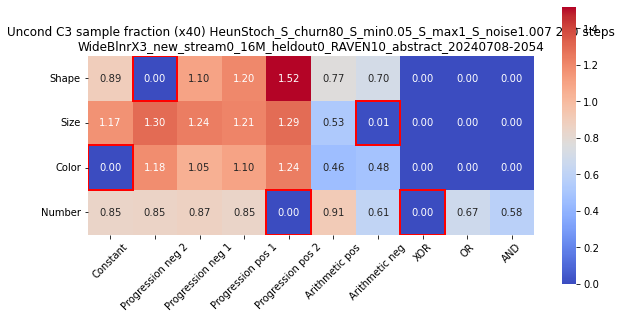

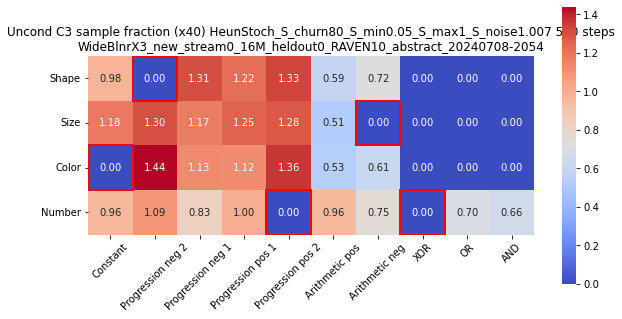

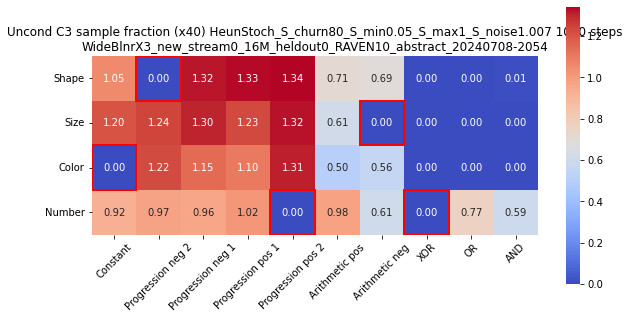

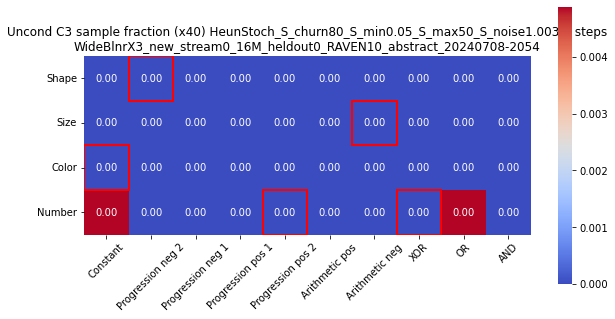

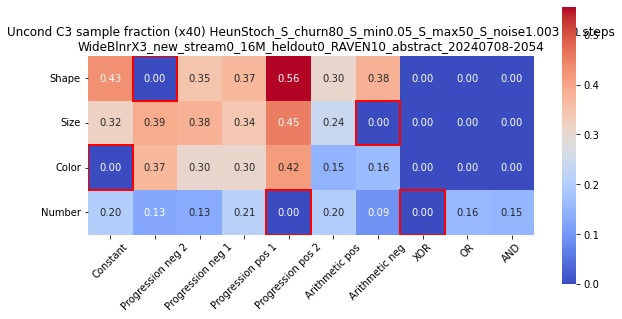

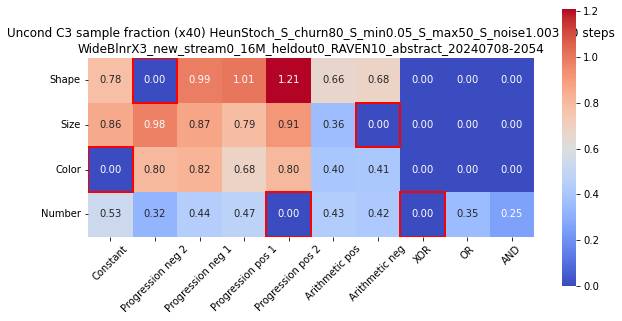

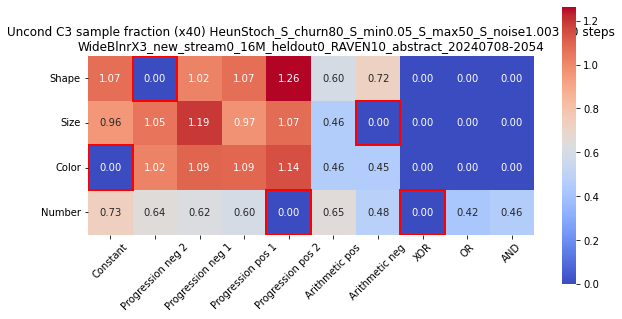

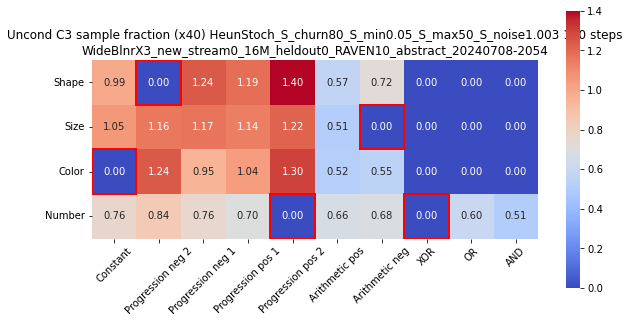

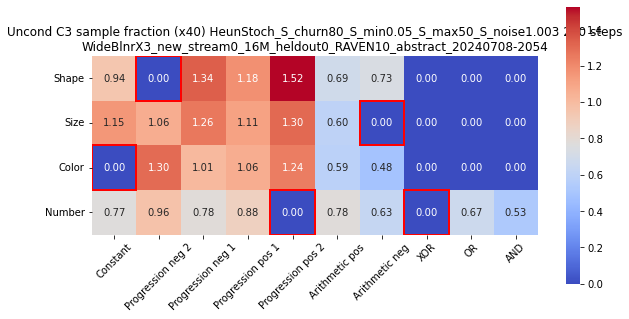

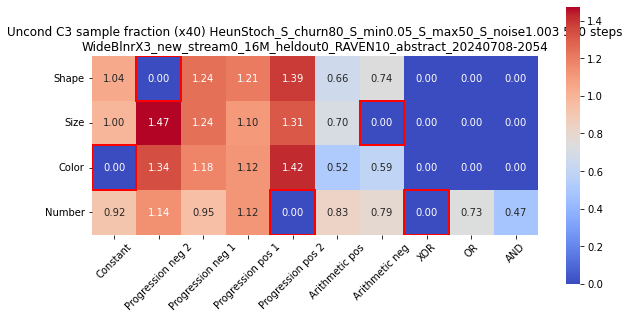

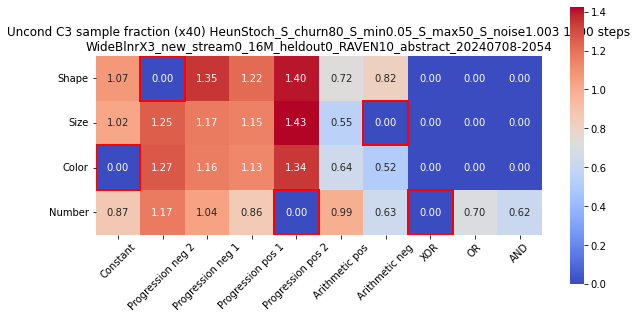

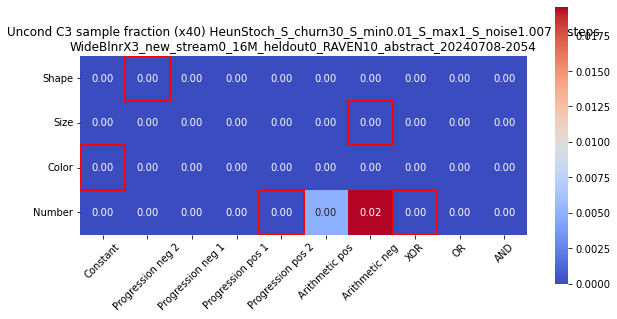

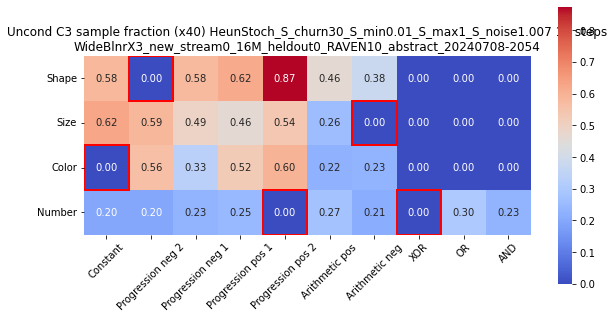

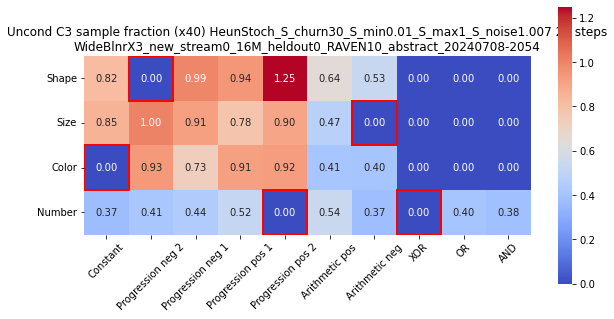

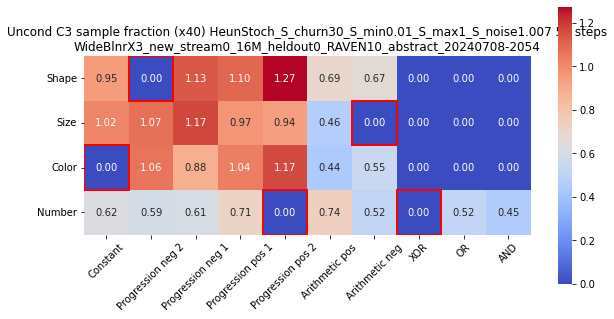

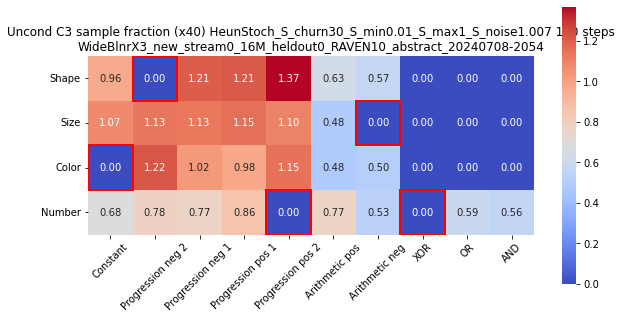

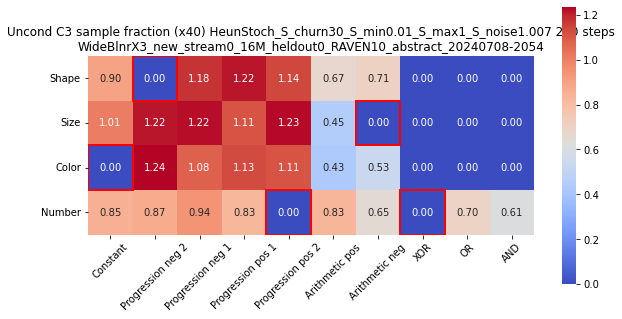

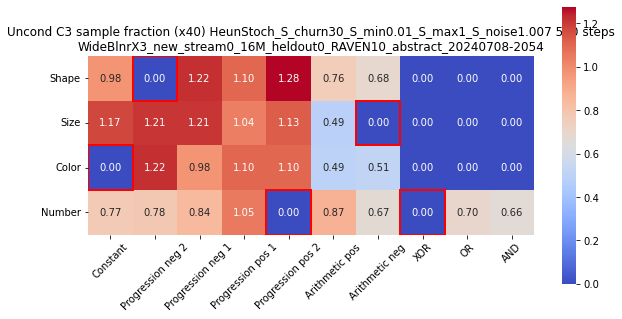

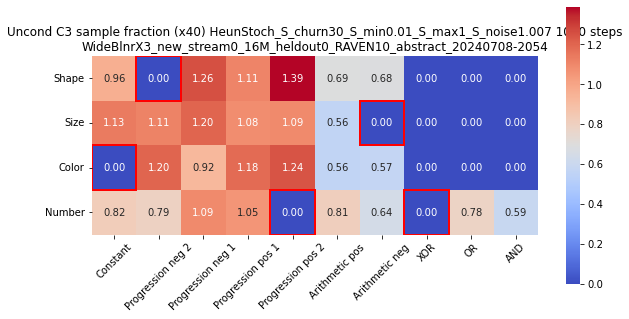

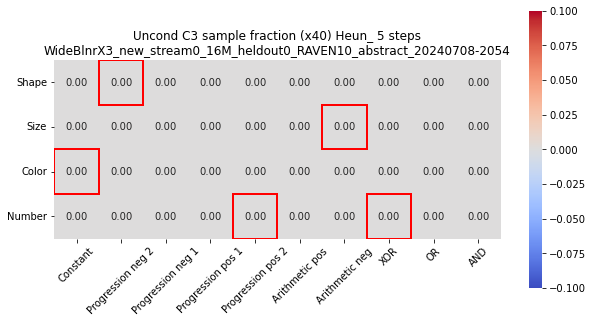

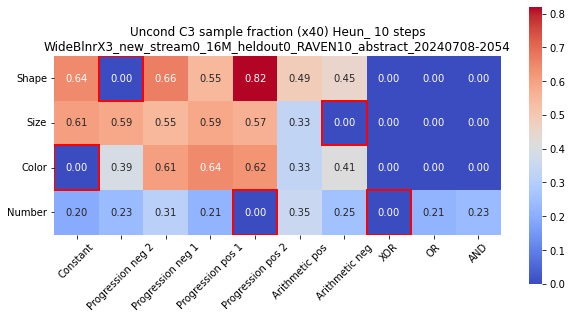

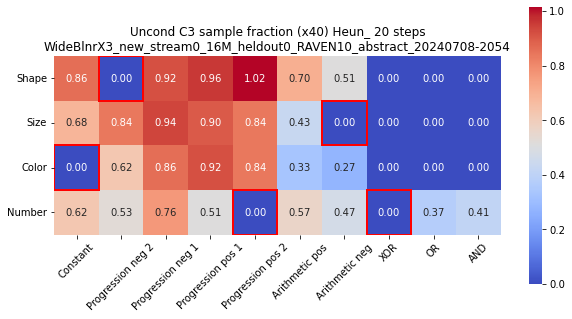

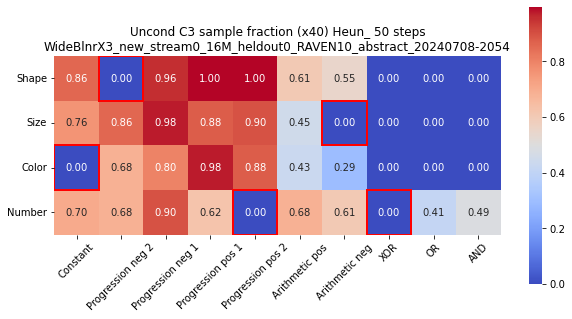

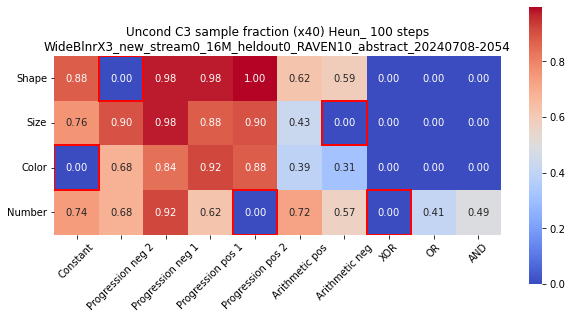

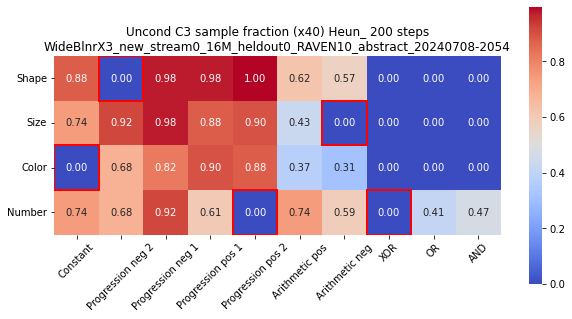

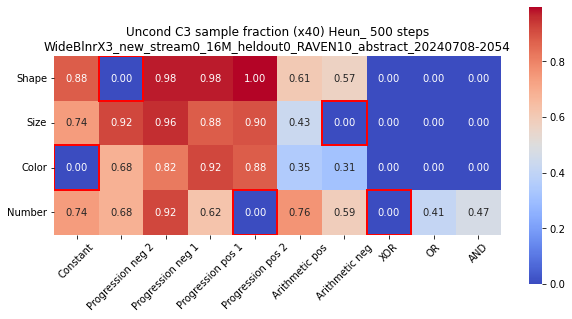

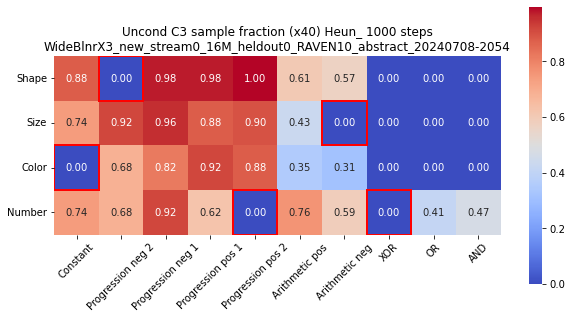

In [167]:
steps = 1000
for sampler in meta_df.sampler.unique():
    for steps in sorted(meta_df.steps.unique()):
        mask = (meta_df.sampler == sampler) & (meta_df.steps == steps) #& (meta_df.param_str == param_str)
        C3_avg = cons3_rule_cnt_mat[mask].sum(axis=1).mean(axis=0) / 2048
        valid_avg = rule_cnt_mat[mask].sum(axis=1).mean(axis=0) / 2048 / 3
        C3_vec = cons3_rule_cnt_mat[mask].mean(axis=0) / 2048 
        valid_vec = rule_cnt_mat[mask].mean(axis=0) / 2048 / 3
        figh = plot_rule_heatmap(C3_vec.reshape(4, 10) * 40, cmap="coolwarm",
                title=f"Uncond C3 sample fraction (x40) {sampler} {steps} steps\n{expname}",)
        saveallforms(figexpdir, f"rule_heatmap_C3_{sampler}_{steps}", figh)
        figh.show()
        figh2 = plot_rule_heatmap(valid_vec.reshape(4, 10) * 40, cmap="coolwarm",
                title=f"Uncond valid row fraction (x40) {sampler} {steps} steps\n{expname}",)
        saveallforms(figexpdir, f"rule_heatmap_valid_{sampler}_{steps}", figh2)
        plt.close(figh2)
        # plt.close(figh)

### Group comparison

In [168]:
rule_ids = np.arange(40)
logic_attr_mask = (rule_ids % 10 >= 7) & (rule_ids  <= 30)
heldout_mask = np.zeros(40, dtype=bool)
heldout_mask[heldout_rules] = True
sum_rule_plot_df = []
for sampler in meta_df.sampler.unique():
    for steps in sorted(meta_df.steps.unique()):
        mask = (meta_df.sampler == sampler) & (meta_df.steps == steps)
        # mask = mask.to_numpy()
        C3_avg = cons3_rule_cnt_mat[mask].sum(axis=1).mean(axis=0) / 2048
        valid_avg = rule_cnt_mat[mask].sum(axis=1).mean(axis=0) / 2048 / 3
        C3_vec = cons3_rule_cnt_mat[mask].mean(axis=0) / 2048 
        valid_vec = rule_cnt_mat[mask].mean(axis=0) / 2048 / 3
        rule_df = pd.DataFrame({"rule_id": np.arange(40), "C3": C3_vec, "valid": valid_vec, 
                                "logic_attr": logic_attr_mask, "heldout": heldout_mask})
        rule_df["sampler"] = sampler
        rule_df["steps"] = steps
        sum_rule_plot_df.append(rule_df)

sum_rule_plot_df = pd.concat(sum_rule_plot_df, axis=0)

In [169]:
sum_rule_plot_df.query("steps == 1000").groupby(["sampler", "heldout"]).mean()

rule_id        C3  \
sampler                                            heldout                      
HeunStoch_S_churn30_S_min0.01_S_max1_S_noise1.007  False       19.2  0.017522   
                                                   True        21.6  0.000000   
HeunStoch_S_churn40_S_min0.05_S_max50_S_noise1.003 False       19.2  0.018101   
                                                   True        21.6  0.000000   
HeunStoch_S_churn80_S_min0.05_S_max1_S_noise1.007  False       19.2  0.018583   
                                                   True        21.6  0.000000   
HeunStoch_S_churn80_S_min0.05_S_max50_S_noise1.003 False       19.2  0.018635   
                                                   True        21.6  0.000000   
Heun_                                              False       19.2  0.013560   
                                                   True        21.6  0.000000   

                                                               valid  \
sampler                                            heldout             
HeunStoch_S_churn30_S_min0.01_S_max1_S_noise1.007  False    0.026040   
                                                   True     0.006510   
HeunStoch_S_churn40_S_min0.05_S_max50_S_noise1.003 False    0.026114   
                                                   True     0.006755   
HeunStoch_S_churn80_S_min0.05_S_max1_S_noise1.007  False    0.026363   
                                                   True     0.006207   
HeunStoch_S_churn80_S_min0.05_S_max50_S_noise1.003 False    0.026146   
                                                   True     0.006063   
Heun_                                              False    0.024767   
                                                   True     0.007227   

                                                            logic_attr   steps  
sampler                                            heldout                      
HeunStoch_S_churn30_S_min0.01_S_max1_S_noise1.007  False      0.257143  1000.0  
                                                   True       0.000000  1000.0  
HeunStoch_S_churn40_S_min0.05_S_max50_S_noise1.003 False      0.257143  1000.0  
                                                   True       0.000000  1000.0  
HeunStoch_S_churn80_S_min0.05_S_max1_S_noise1.007  False      0.257143  1000.0  
                                                   True       0.000000  1000.0  
HeunStoch_S_churn80_S_min0.05_S_max50_S_noise1.003 False      0.257143  1000.0  
                                                   True       0.000000  1000.0  
Heun_                                              False      0.257143  1000.0  
                                                   True       0.000000  1000.0

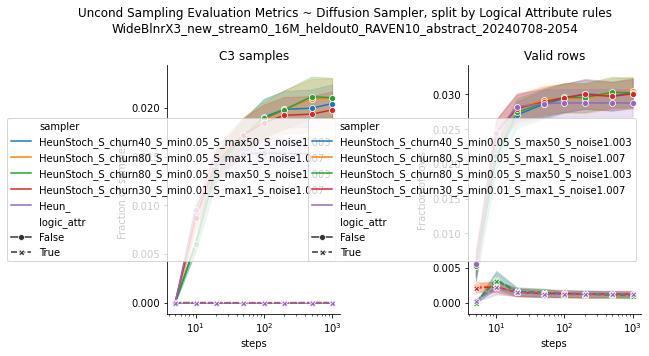

In [170]:
figh, axs = plt.subplots(1, 2, figsize=(8.5, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=sum_rule_plot_df, x="steps", y="C3", 
             style="logic_attr", hue='sampler', markers=True, errorbar='se')
plt.xscale("log")
plt.ylabel("Fraction of samples")
plt.title("C3 samples")
plt.subplot(1, 2, 2)
sns.lineplot(data=sum_rule_plot_df, x="steps", y="valid", 
             style="logic_attr", hue='sampler', markers=True, errorbar='se')
plt.xscale("log")
plt.ylabel("Fraction of rows")
plt.title("Valid rows")
plt.suptitle(f"Uncond Sampling Evaluation Metrics ~ Diffusion Sampler, split by Logical Attribute rules\n{expname}",)
plt.tight_layout()
saveallforms(figexpdir, "sampler_eval_metric_rule_split_logicattr", figh)
plt.show()

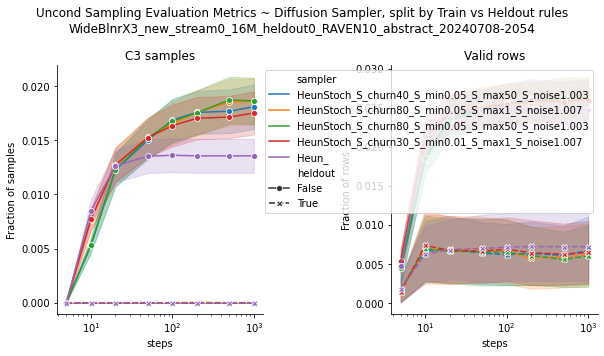

In [171]:
figh, axs = plt.subplots(1, 2, figsize=(8.5, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=sum_rule_plot_df, x="steps", y="C3", 
             style="heldout", hue='sampler', markers=True, errorbar='se', legend=False)
plt.xscale("log")
plt.ylabel("Fraction of samples")
plt.title("C3 samples")
plt.subplot(1, 2, 2)
sns.lineplot(data=sum_rule_plot_df, x="steps", y="valid", 
             style="heldout", hue='sampler', markers=True, errorbar='se', legend=True)
plt.xscale("log")
plt.ylabel("Fraction of rows")
plt.title("Valid rows")
plt.suptitle(f"Uncond Sampling Evaluation Metrics ~ Diffusion Sampler, split by Train vs Heldout rules\n{expname}",)
plt.tight_layout()
saveallforms(figexpdir, "sampler_eval_metric_rule_split_train_heldout", figh)
plt.show()

### Scratch

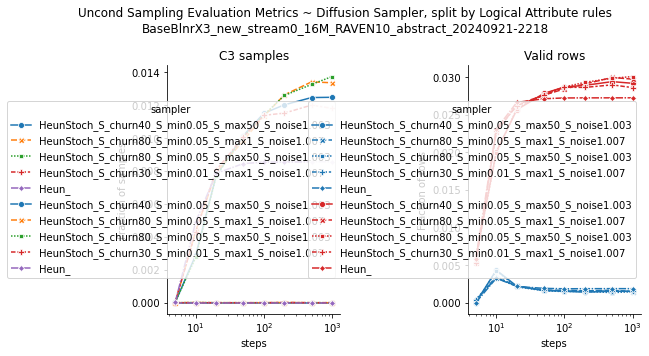

In [140]:
rule_ids = np.arange(40)
rule_mask = (rule_ids % 10 >= 7) & (rule_ids  <= 30)
sum_plot_df = []
for sampler in meta_df.sampler.unique():
    for steps in sorted(meta_df.steps.unique()):
        mask = (meta_df.sampler == sampler) & (meta_df.steps == steps)
        # mask = mask.to_numpy()
        C3_avg = cons3_rule_cnt_mat[mask].sum(axis=1).mean(axis=0) / 2048
        valid_avg = rule_cnt_mat[mask].sum(axis=1).mean(axis=0) / 2048 / 3
        C3_vec = cons3_rule_cnt_mat[mask].mean(axis=0) / 2048 
        valid_vec = rule_cnt_mat[mask].mean(axis=0) / 2048 / 3
        inmask_C3 = C3_vec[rule_mask].mean()
        outmask_C3 = C3_vec[~rule_mask].mean()
        inmask_valid = valid_vec[rule_mask].mean()
        outmask_valid = valid_vec[~rule_mask].mean()
        sum_plot_df.append({"sampler": sampler, "steps": steps, "inmask_C3": inmask_C3, "outmask_C3": outmask_C3,
                            "inmask_valid": inmask_valid, "outmask_valid": outmask_valid})

sum_plot_df = pd.DataFrame(sum_plot_df)
figh, axs = plt.subplots(1, 2, figsize=(8.5, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=sum_plot_df, x="steps", y="inmask_C3", style="sampler", hue='sampler', markers=True)
sns.lineplot(data=sum_plot_df, x="steps", y="outmask_C3", style="sampler", hue='sampler', markers=True)
plt.xscale("log")
plt.ylabel("Fraction of samples")
plt.title("C3 samples")
plt.subplot(1, 2, 2)
sns.lineplot(data=sum_plot_df, x="steps", y="inmask_valid", style="sampler", markers=True, color="tab:blue") #hue='sampler', 
sns.lineplot(data=sum_plot_df, x="steps", y="outmask_valid", style="sampler", markers=True, color="tab:red") #hue='sampler', 
plt.xscale("log")
plt.ylabel("Fraction of rows")
plt.title("Valid rows")
plt.suptitle(f"Uncond Sampling Evaluation Metrics ~ Diffusion Sampler, split by Logical Attribute rules\n{expname}",)
plt.tight_layout()
saveallforms(figexpdir, "sampler_eval_metric_rule_split_logicattr", figh)
plt.show()

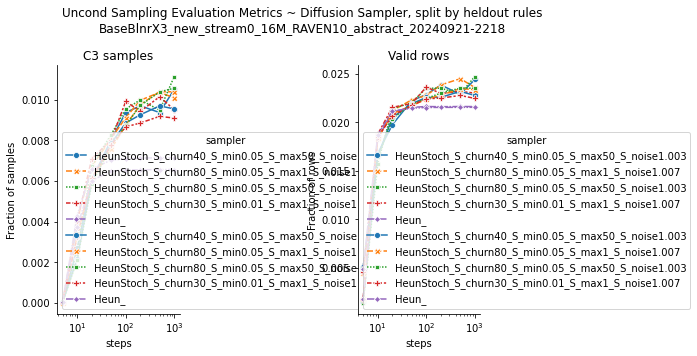

In [141]:
# rule_ids = np.arange(40)
rule_mask = np.zeros(40, dtype=bool)
rule_mask[heldout_rules] = True
sum_plot_df = []
for sampler in meta_df.sampler.unique():
    for steps in sorted(meta_df.steps.unique()):
        mask = (meta_df.sampler == sampler) & (meta_df.steps == steps)
        # mask = mask.to_numpy()
        C3_avg = cons3_rule_cnt_mat[mask].sum(axis=1).mean(axis=0) / 2048
        valid_avg = rule_cnt_mat[mask].sum(axis=1).mean(axis=0) / 2048 / 3
        C3_vec = cons3_rule_cnt_mat[mask].mean(axis=0) / 2048 
        valid_vec = rule_cnt_mat[mask].mean(axis=0) / 2048 / 3
        inmask_C3 = C3_vec[rule_mask].mean()
        outmask_C3 = C3_vec[~rule_mask].mean()
        inmask_valid = valid_vec[rule_mask].mean()
        outmask_valid = valid_vec[~rule_mask].mean()
        sum_plot_df.append({"sampler": sampler, "steps": steps, "inmask_C3": inmask_C3, "outmask_C3": outmask_C3,
                            "inmask_valid": inmask_valid, "outmask_valid": outmask_valid})

sum_plot_df = pd.DataFrame(sum_plot_df)
figh, axs = plt.subplots(1, 2, figsize=(8.5, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=sum_plot_df, x="steps", y="inmask_C3", style="sampler", hue='sampler', markers=True)
sns.lineplot(data=sum_plot_df, x="steps", y="outmask_C3", style="sampler", hue='sampler', markers=True)
plt.xscale("log")
plt.ylabel("Fraction of samples")
plt.title("C3 samples")
plt.subplot(1, 2, 2)
sns.lineplot(data=sum_plot_df, x="steps", y="inmask_valid", style="sampler", hue='sampler', markers=True)
sns.lineplot(data=sum_plot_df, x="steps", y="outmask_valid", style="sampler", hue='sampler', markers=True)
plt.xscale("log")
plt.ylabel("Fraction of rows")
plt.title("Valid rows")
plt.suptitle(f"Uncond Sampling Evaluation Metrics ~ Diffusion Sampler, split by heldout rules\n{expname}", )
plt.tight_layout()
saveallforms(figexpdir, "sampler_eval_metric_rule_split_train_heldout", figh)
plt.show()

### Load in models

In [27]:
def extract_parameter_list(expdir):
    file_list = glob.glob(join(expdir, "uncond_samples", "sample_rule_eval_*.pt"))
    # Regular expression to extract parts from the filename
    pattern = r'sample_rule_eval_(\d+)_(ddim|ddpm)(\d+)_rep(\d+)\.pt'
    # Create a list to store the extracted results
    extracted_data = []
    # Iterate through all matching files
    for file in file_list:
        file_name = os.path.basename(file)  # Get the file name only, without the directory path
        match = re.search(pattern, file_name)
        if match:
            epoch = int(match.group(1))  # e.g., 1000000
            sampler = match.group(2)
            steps = int(match.group(3))  # e.g., 200 (from ddim200)
            rep = int(match.group(4))  # e.g., 6 (from rep6)
            # Append the extracted parts to the list
            extracted_data.append((file_name, epoch, sampler, steps, rep))
        else:
            print(f"Pattern not found in {file_name}")
    print(f"Extracted data from {expdir}")
    print(f"Found {len(extracted_data)} matching files")
    print(f"Example file names: {extracted_data[:5]}")
    # Print the extracted data for all files
    # for data in extracted_data:
    #     print(f"File: {data[0]} -> 1000000: {data[1]}, ddim: {data[2]}, rep: {data[3]}")

Extracted data from /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiT/results/090-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout0_20240711-0204
Found 160 matching files
Example file names: [('sample_rule_eval_1000000_ddim200_rep6.pt', 1000000, 'ddim', 200, 6), ('sample_rule_eval_1000000_ddpm500_rep1.pt', 1000000, 'ddpm', 500, 1), ('sample_rule_eval_1000000_ddpm200_rep4.pt', 1000000, 'ddpm', 200, 4), ('sample_rule_eval_1000000_ddpm20_rep5.pt', 1000000, 'ddpm', 20, 5), ('sample_rule_eval_1000000_ddim5_rep4.pt', 1000000, 'ddim', 5, 4)]


In [ ]:
exproot = r"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiT/results"
expname = r"090-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout0_20240711-0204"
expdir = join(exproot, expname)
ckptdir = join(expdir, "checkpoints")
ckpt_path = join(ckptdir, "1000000.pt")
state_dict = th.load(ckpt_path, )
model_DiT.load_state_dict(state_dict["model"])
model_DiT.to("cuda").eval();
savedir = join(expdir, "uncond_samples")
os.makedirs(savedir, exist_ok=True)

In [22]:
!ls $expdir/uncond_samples/

1000000_ddim1000_rep0.pt  sample_rule_eval_1000000_ddim1000_rep0.pt
1000000_ddim1000_rep1.pt  sample_rule_eval_1000000_ddim1000_rep1.pt
1000000_ddim1000_rep2.pt  sample_rule_eval_1000000_ddim1000_rep2.pt
1000000_ddim1000_rep3.pt  sample_rule_eval_1000000_ddim1000_rep3.pt
1000000_ddim1000_rep4.pt  sample_rule_eval_1000000_ddim1000_rep4.pt
1000000_ddim1000_rep5.pt  sample_rule_eval_1000000_ddim1000_rep5.pt
1000000_ddim1000_rep6.pt  sample_rule_eval_1000000_ddim1000_rep6.pt
1000000_ddim1000_rep7.pt  sample_rule_eval_1000000_ddim1000_rep7.pt
1000000_ddim1000_rep8.pt  sample_rule_eval_1000000_ddim1000_rep8.pt
1000000_ddim1000_rep9.pt  sample_rule_eval_1000000_ddim1000_rep9.pt
1000000_ddim100_rep0.pt   sample_rule_eval_1000000_ddim100_rep0.pt
1000000_ddim100_rep1.pt   sample_rule_eval_1000000_ddim100_rep1.pt
1000000_ddim100_rep2.pt   sample_rule_eval_1000000_ddim100_rep2.pt
1000000_ddim100_rep3.pt   sample_rule_eval_1000000_ddim100_rep3.pt
1000000_ddim100_rep4.pt   sample_rule_eval_1000000_d